# Data Acquisition
### Data was garthered from Kaggle and unsplash.com. Then the specified number of images was hand selected. This was neccessary due to blurry, noisy images.

In [4]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import Input, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
# Load the images from dropbox and download best model

# Download dataset
!wget --no-check-certificate "https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0" -O dataset.zip

# Unzip the dataset
!unzip dataset.zip

#!unzip 'AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=1'

# renaming the model for easier use
#old_file_name = "MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=1"
#new_file_name = "MT_NHF_0_81.keras"
#os.rename(old_file_name, new_file_name)

--2024-12-08 19:28:03--  https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc221a8b4ee74350d8b14814b122.dl.dropboxusercontent.com/zip_download_get/CDRVpr7GcNlLxTFhfMNhITSBE_yDWzpQoR3jBX1gQ9qthV1p4dPU_swmpu5Pgd_4WNOMHuiVXiBVzL9fLgpdQ3akgeP8Bs1569Nw_md4bLM3hw# [following]
--2024-12-08 19:28:05--  https://uc221a8b4ee74350d8b14814b122.dl.dropboxusercontent.com/zip_download_get/CDRVpr7GcNlLxTFhfMNhITSBE_yDWzpQoR3jBX1gQ9qthV1p4dPU_swmpu5Pgd_4WNOMHuiVXiBVzL9fLgpdQ3akgeP8Bs1569Nw_md4bLM3hw
Resolving uc221a8b4ee74350d8b14814b122.dl.dropboxusercontent.com (uc221a8b4ee74350d8b14814b122.dl.dropboxusercontent.com)... 162.125.85.15, 2620:100:6035:15::a27d:550f
Connecting to uc221a8b4ee74350

# Data Cleansing

In [6]:
# Safely load images with error handling
def load_images_from_folder(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                img = Image.open(file_path)
                image_list.append(img)
            except (IOError) as e:
                print(f"Error loading image {filename}: {e}")
    return image_list

# Load the classes to lists with error handling for corrupted images
books_orig_size = load_images_from_folder('books')
shoes_orig_size = load_images_from_folder('shoes')
chairs_orig_size = load_images_from_folder('chairs')
fridges_orig_size = load_images_from_folder('fridges')
tables_orig_size = load_images_from_folder('tables')

Error loading image Intentional_error.txt: cannot identify image file '/content/books/Intentional_error.txt'


### Display Images
### Dispaly some images to test if proper loading.

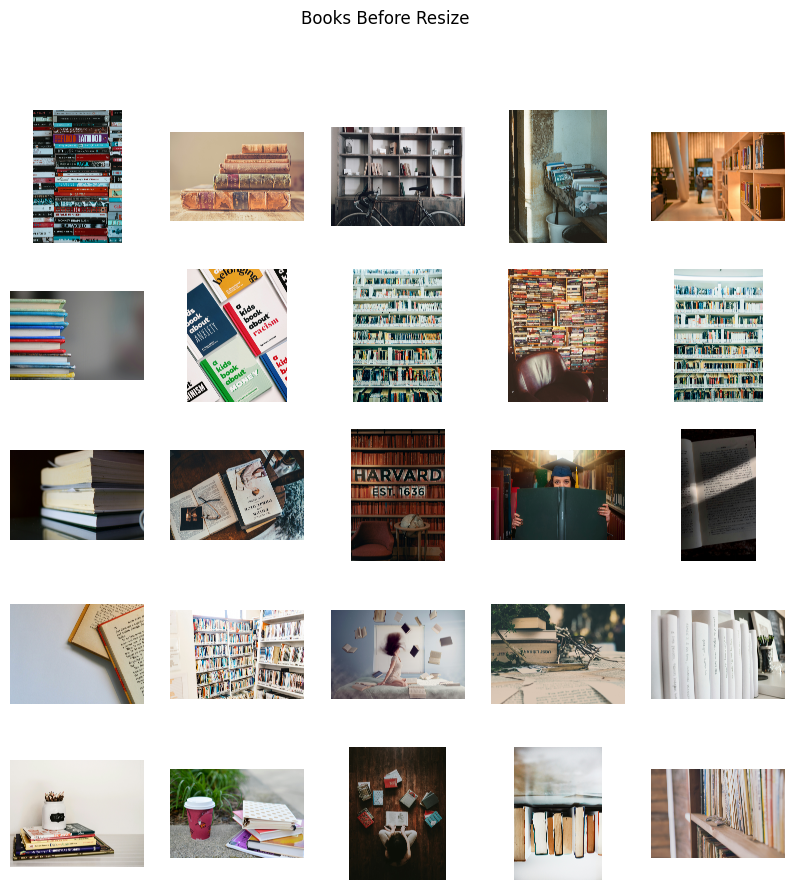

In [7]:
def display_images_from_list(images, title, labels=None):
    if labels:
        combined = list(zip(images, labels))
        random.shuffle(combined)
        images, labels = zip(*combined)
    else:
        labels = [None] * len(images)

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(title)

    for i, (ax, img) in enumerate(zip(axes.flatten(), images[:25])):
        ax.imshow(img)
        if labels:
            ax.set_title(labels[i], fontsize=8)
        ax.axis('off')

    plt.show()

display_images_from_list(books_orig_size, 'Books Before Resize')

## Image Resize
### Resize images to 256 x 256 for better performance. Also return the appropriate label for the image.

In [8]:
def Img_Resize(image_list, image_type, output_size=(256, 256)):
    output_size = (256, 256) # New size of images
    # Labels for classes
    type_dict = {'book': 'book', 'chair': 'furniture', 'table': 'furniture', 'fridge': 'furniture', 'shoe': "shoe"}
    labels = {f"{image_type}_{i}": type_dict[image_type] for i in range(1, len(image_list) + 1)}
    resized_images = []

    for img in image_list:
        try:
            resized_img = img.resize(output_size)
            resized_images.append(resized_img)
        except Exception as e:
            print(f"Error resizing image: {e}")

    return resized_images, labels

# Instantiate resized images and labels
books, books_labels = Img_Resize(books_orig_size, 'book')
books, books_labels = books[:50], dict(itertools.islice(books_labels.items(), 50))

shoes, shoes_labels = Img_Resize(shoes_orig_size, 'shoe')
shoes, shoes_labels = shoes[:50], dict(itertools.islice(shoes_labels.items(), 50))

chairs, chairs_labels = Img_Resize(chairs_orig_size, 'chair')
chairs, chairs_labels = chairs[:17], dict(itertools.islice(chairs_labels.items(), 17))

fridges, fridges_labels = Img_Resize(fridges_orig_size, 'fridge')
fridges, fridges_labels = fridges[:16], dict(itertools.islice(fridges_labels.items(), 16))

tables, tables_labels = Img_Resize(tables_orig_size, 'table')
tables, tables_labels = tables[:17], dict(itertools.islice(tables_labels.items(), 17))

# Update Furniture list
# It is a combination of chairs, fridges and tables
furniture = chairs + fridges + tables
furniture_labels = {}
furniture_labels.update(chairs_labels)
furniture_labels.update(fridges_labels)
furniture_labels.update(tables_labels)

### Test Furniture label correctness

In [9]:
print(furniture_labels)

{'chair_1': 'furniture', 'chair_2': 'furniture', 'chair_3': 'furniture', 'chair_4': 'furniture', 'chair_5': 'furniture', 'chair_6': 'furniture', 'chair_7': 'furniture', 'chair_8': 'furniture', 'chair_9': 'furniture', 'chair_10': 'furniture', 'chair_11': 'furniture', 'chair_12': 'furniture', 'chair_13': 'furniture', 'chair_14': 'furniture', 'chair_15': 'furniture', 'chair_16': 'furniture', 'chair_17': 'furniture', 'fridge_1': 'furniture', 'fridge_2': 'furniture', 'fridge_3': 'furniture', 'fridge_4': 'furniture', 'fridge_5': 'furniture', 'fridge_6': 'furniture', 'fridge_7': 'furniture', 'fridge_8': 'furniture', 'fridge_9': 'furniture', 'fridge_10': 'furniture', 'fridge_11': 'furniture', 'fridge_12': 'furniture', 'fridge_13': 'furniture', 'fridge_14': 'furniture', 'fridge_15': 'furniture', 'fridge_16': 'furniture', 'table_1': 'furniture', 'table_2': 'furniture', 'table_3': 'furniture', 'table_4': 'furniture', 'table_5': 'furniture', 'table_6': 'furniture', 'table_7': 'furniture', 'table_8

# Display Images with assigned Labels

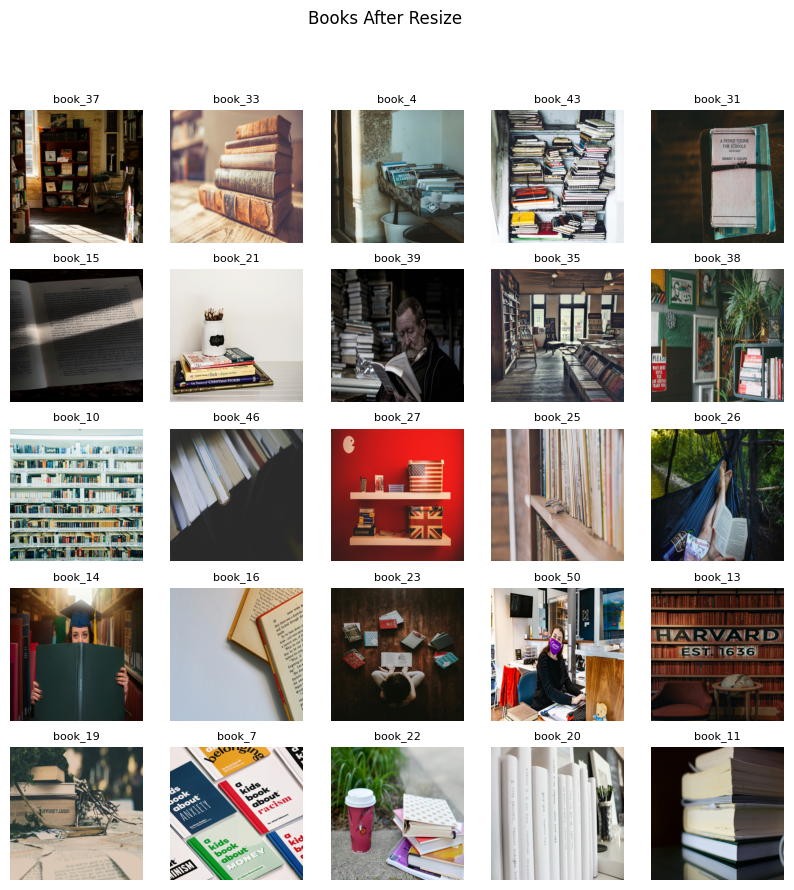

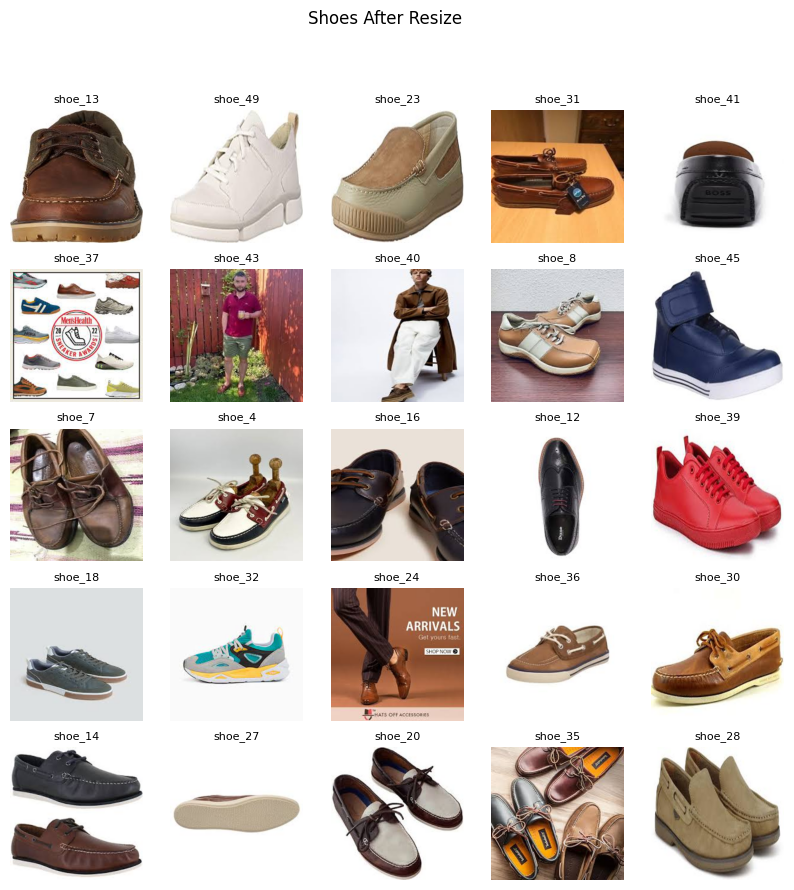

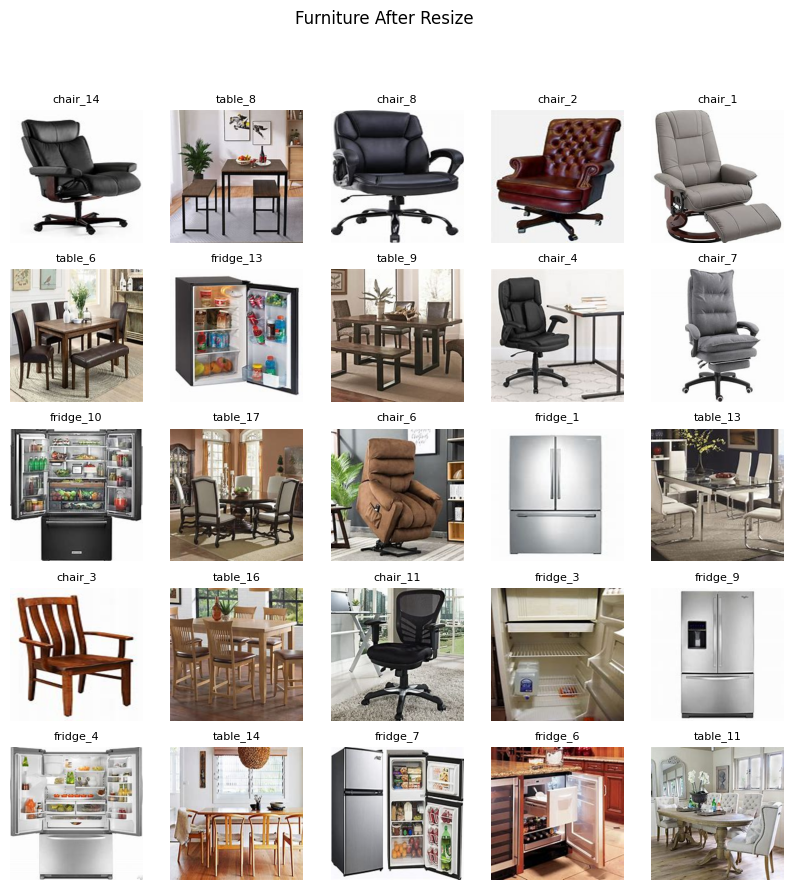

In [10]:
# making sure that label assignment is correct
display_images_from_list(books, 'Books After Resize', books_labels)
display_images_from_list(shoes, 'Shoes After Resize', shoes_labels)
display_images_from_list(furniture, 'Furniture After Resize', furniture_labels)

### Count the number of items in each class
#### Combine the data to make a pie chart

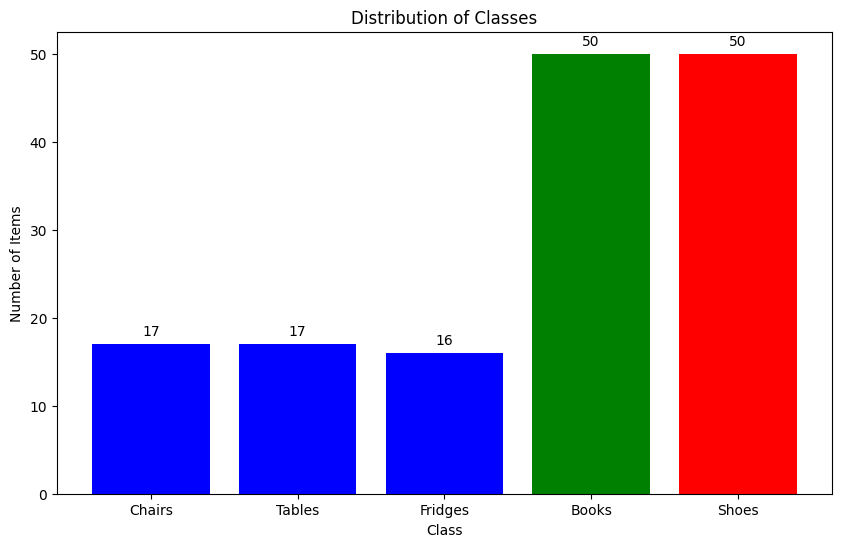

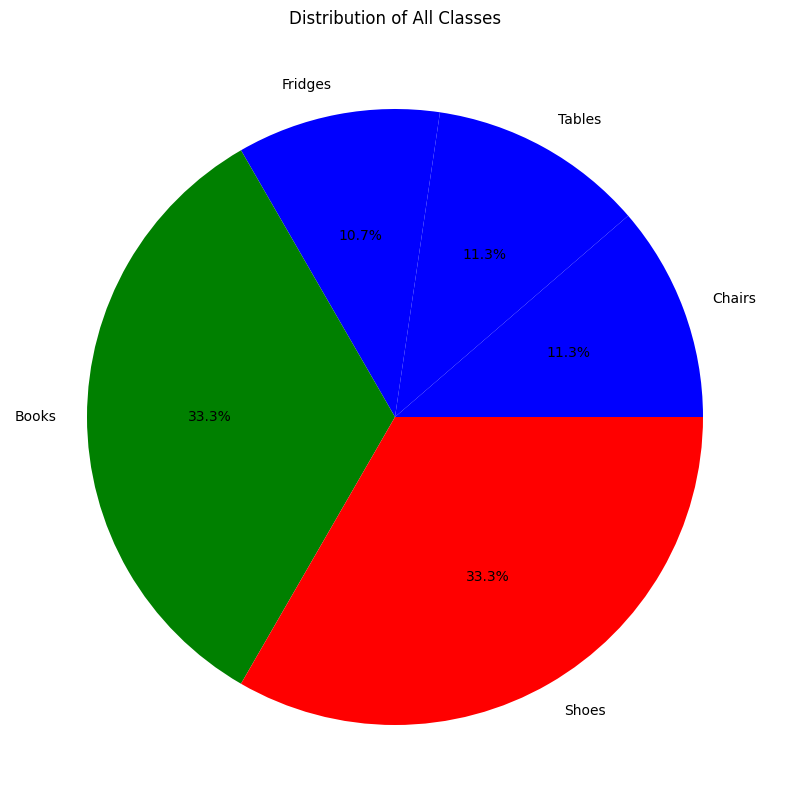

In [11]:
all_counts = {
    'Chairs': len(chairs),
    'Tables': len(tables),
    'Fridges': len(fridges),
    'Books': len(books),
    'Shoes': len(shoes)
}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(all_counts.keys(), all_counts.values(), color=['blue', 'blue', 'blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(all_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes')
plt.figure(figsize=(10, 10))
plt.pie(all_counts.values(), labels=all_counts.keys(), autopct='%1.1f%%', colors=['blue', 'blue', 'blue', 'green', 'red'])
plt.title('Distribution of All Classes')
plt.show()

# Data Preparation
### Split data into train, validation and test sets. Test and Validation set size is 14%, which is 21 images. This is significant because this way we have an equal number of images from each class while having a big enough test and validation dataset size.

In [12]:
# Convert data to the correct format
all_images = furniture + shoes + books
all_labels_list = list(furniture_labels.values()) + list(shoes_labels.values()) + list(books_labels.values())

# Since data is ordered this creates 3 arrays, each with one type of image (book, furniture or shoe)
classes = np.array_split(all_images, 3)
labels = np.array_split(all_labels_list, 3)

# Set train,test and val counts per class
num_test, num_val = 7, 7
num_train = 50 - num_test - num_val

# Create the splits
train_images = sum([list(cls[:num_train]) for cls in classes], [])
train_labels = sum([list(lbl[:num_train]) for lbl in labels], [])
val_images = sum([list(cls[num_train:num_train + num_val]) for cls in classes], [])
val_labels = sum([list(lbl[num_train:num_train + num_val]) for lbl in labels], [])
test_images = sum([list(cls[num_train + num_val:]) for cls in classes], [])
test_labels = sum([list(lbl[num_train + num_val:]) for lbl in labels], [])

# Randomize train data, since we didn't use train_test_split
# This step helps the model generalize better
combined = list(zip(train_images, train_labels))
random.seed(3)
random.shuffle(combined)
train_images, train_labels = zip(*combined)
train_images = list(train_images)
train_labels = list(train_labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 108
Validation set size: 21
Test set size: 21


### Data Statistics

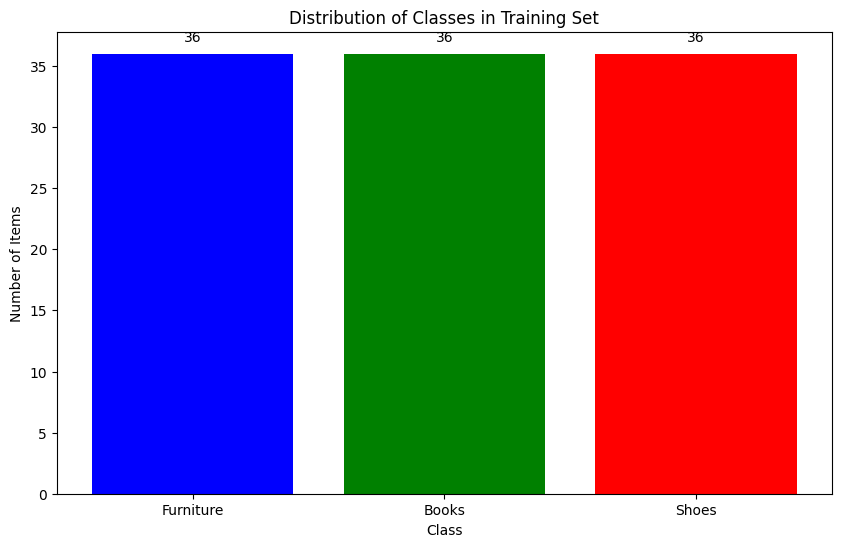

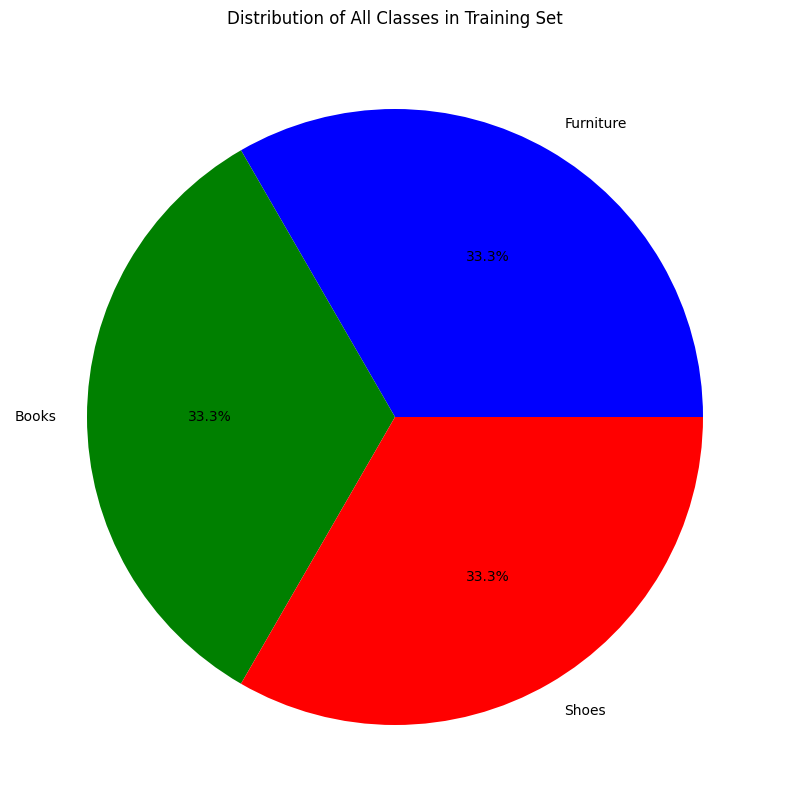

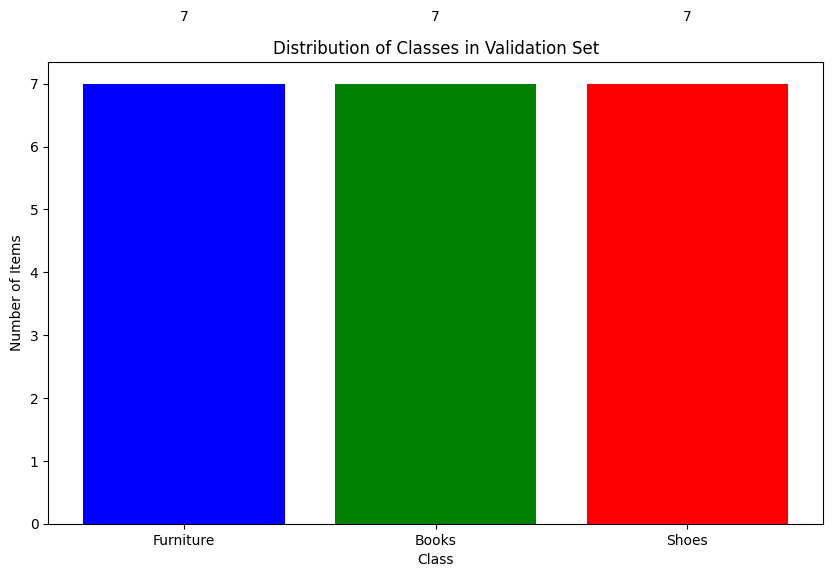

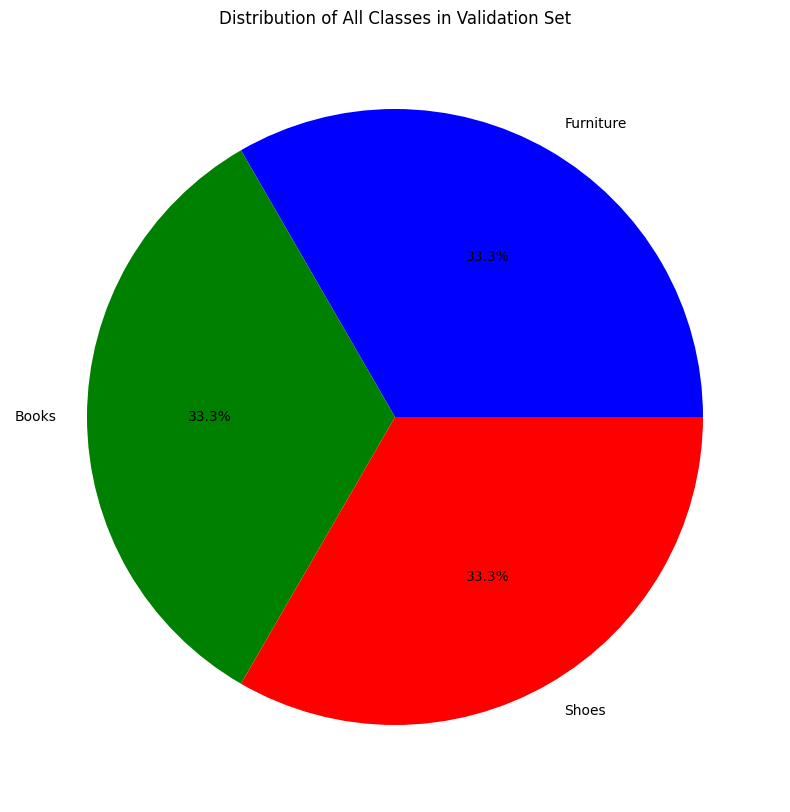

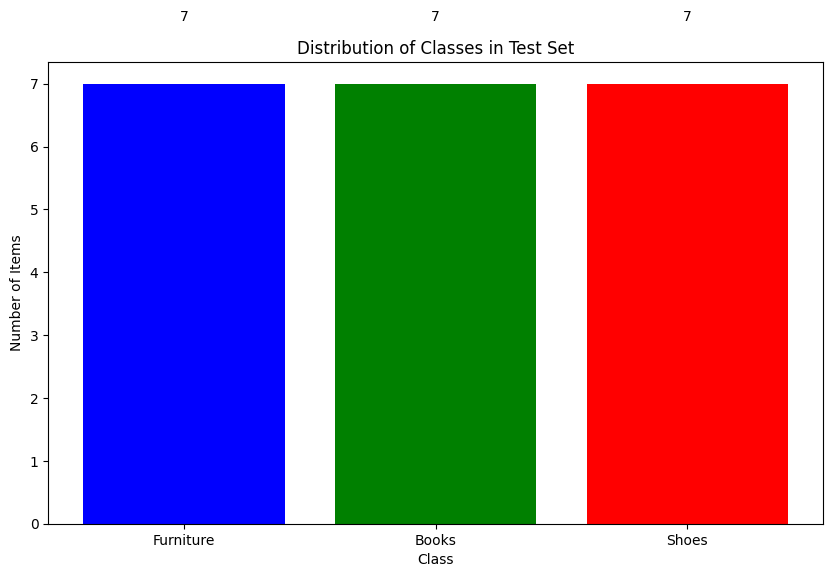

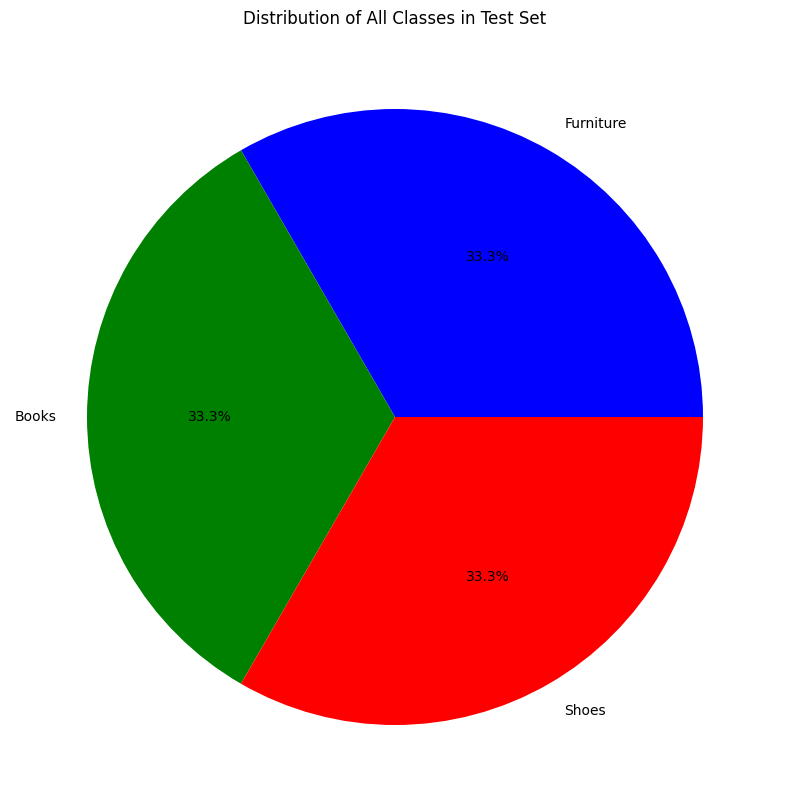

In [13]:
train_counts = {
    'Furniture': sum(1 for label in train_labels if label == 'furniture'),
    'Books': sum(1 for label in train_labels if label == 'book'),
    'Shoes': sum(1 for label in train_labels if label == 'shoe')
}

# Plot the distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(train_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Training Set')
plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Training Set')
plt.show()

# Count the number of items in each class in the validation set
val_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the validation set
plt.figure(figsize=(10, 6))
plt.bar(val_counts.keys(), val_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(val_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Validation Set')
plt.figure(figsize=(10, 10))
plt.pie(val_counts.values(), labels=val_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Validation Set')
plt.show()

# Count the number of items in each class in the test set
test_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the test set
plt.figure(figsize=(10, 6))
plt.bar(test_counts.keys(), test_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(test_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Test Set')
plt.figure(figsize=(10, 10))
plt.pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Test Set')
plt.show()

# Baseline models

##Random choosing
### This model chooses an output randomly, each class having a chance of 33.3%. For better representation we predict the labels of the training set.

Accuracy: 0.35



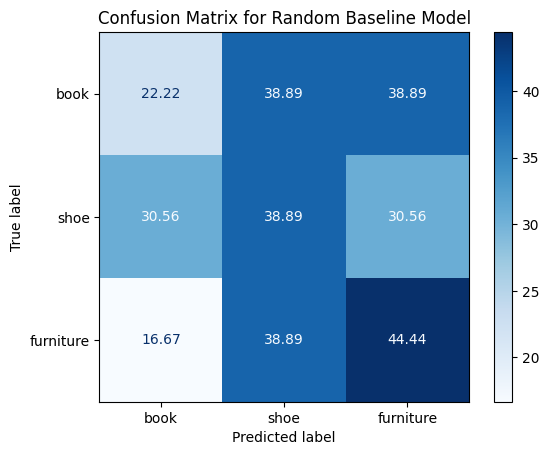

In [14]:
classes = list(set(val_labels))
num_samples = len(train_images)

# Retrun random predictions for every image of the set
def random_baseline_predictions(num_samples):
    return [random.choice(classes) for _ in range(num_samples)]

true_labels = train_labels
random_predictions = random_baseline_predictions(num_samples)

# Convert the random predictions and true labels to arrays for evaluation
random_predictions_array = np.array(random_predictions)
true_labels_array = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels_array, random_predictions_array)
print(f"Accuracy: {accuracy:.2f}\n")

# Confusion matrix
conf_matrix = confusion_matrix(true_labels_array, random_predictions_array, labels=classes)
conf_matrix_percent = np.nan_to_num(conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Random Baseline Model')
plt.show()

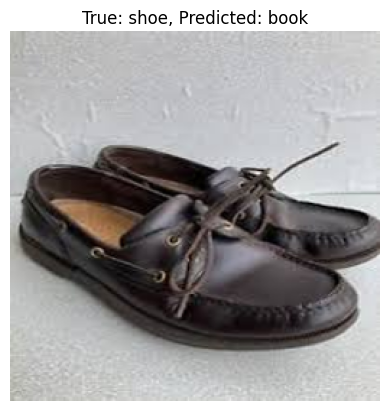

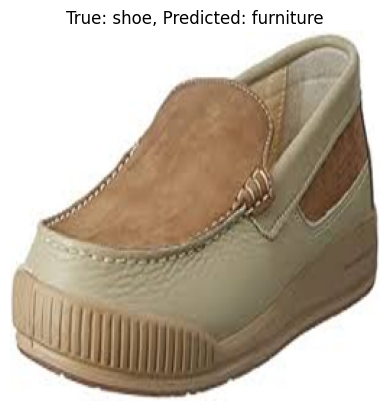

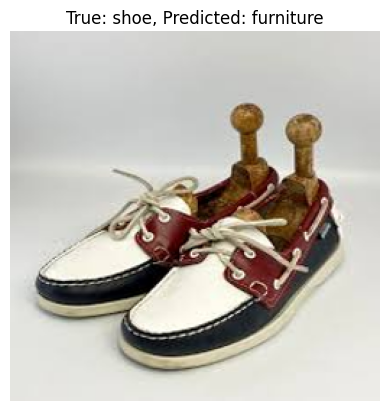

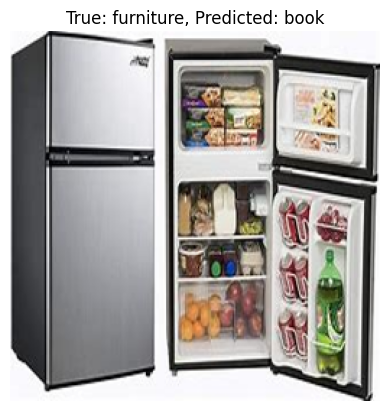

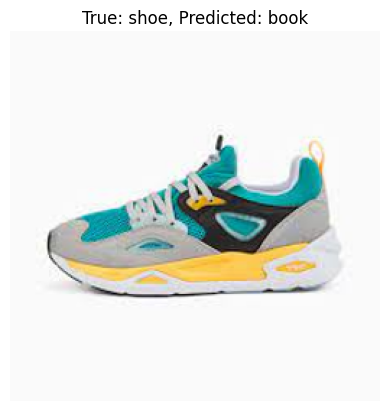

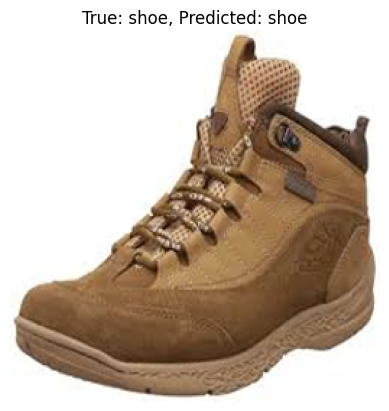

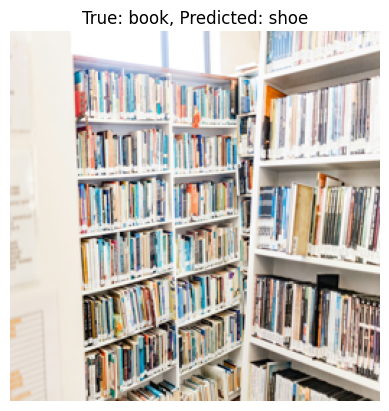

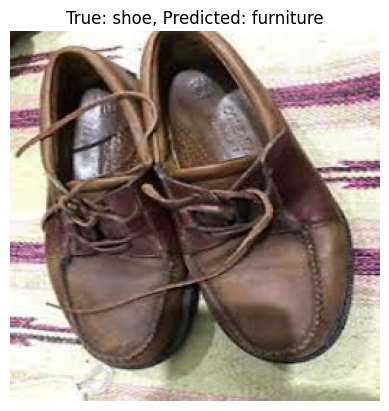

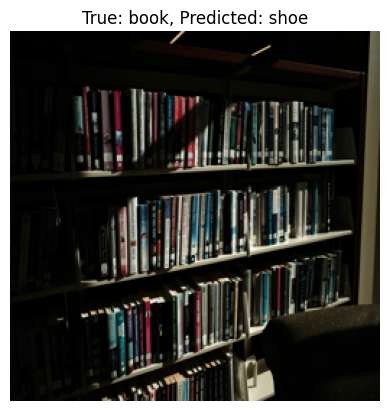

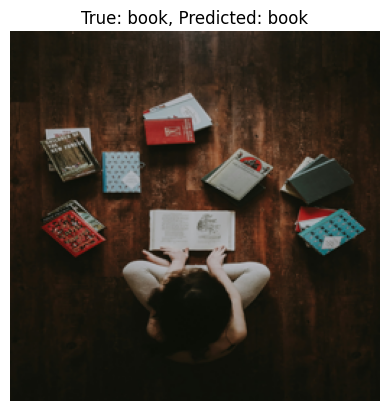

In [15]:
# Display some example images with predicted and true labels
def display_predictions(num_samples_to_show=10):
    for i in range(num_samples_to_show):
        true_label = true_labels[i]
        predicted_label = random_predictions[i]
        image = train_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

display_predictions()

## Baseline neural network model

We chose a quite simple model, with only two convolutional layers. After one-hot-encoding the labels, and converting the images to arrays, we trained the model for 10 epochs, with the batchsize of 16.

In [16]:
def baseline_cnn(input_shape=(256, 256, 3), num_classes=3):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_cnn = baseline_cnn()

# One-Hot-Encode Labels and convert Images to array for training
true_labels_categorical = to_categorical([classes.index(label) for label in true_labels], num_classes=len(classes))
train_images = np.array(train_images)

baseline_cnn.fit(train_images, true_labels_categorical, epochs=10, batch_size=16)

Epoch 1/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.2237 - loss: 4997.6802 

KeyboardInterrupt: 

### Evaluate Baseline CNN
#### As we can see, the baseline neural net models accuracy is around 30%, which means it's basically random guessing. It hardly ever predicted book labels, and when it did, it was incorrect -> the model could not learn the patterns.

In [ ]:
# Convert Images as before
test_images = np.array(test_images)

# Eval
predictions = baseline_cnn.predict(test_images)
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

# Calculate accuracy for the trained model
trained_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Trained Model Accuracy: {trained_accuracy:.2f}\n")

# Confusion matrix
trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
trained_conf_matrix_percent = np.nan_to_num(trained_conf_matrix / trained_conf_matrix.sum(axis=1, keepdims=True) * 100)

trained_disp = ConfusionMatrixDisplay(confusion_matrix=trained_conf_matrix_percent, display_labels=classes)
trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Trained CNN Model')
plt.show()

### Display some images with predicted and real labels

In [ ]:
def display_trained_predictions(num_samples_to_show=5):
    for i in range(num_samples_to_show):
        true_label = test_labels[i]
        predicted_label = predicted_labels[i]
        image = test_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

display_trained_predictions()

# Iterative Neural Network Development

## Image Augmentation
Because of the limited dataset (150 images) we used image augmentation for every model, to try to prevent overfitting and to generate more data for the models to train on. We used zooming, horizontal flipping, rotation etc. as augmentation. This way, the  model's generalization ability will improve.  

Also we included early stopping with every model, to prevent the model from overfitting. Patience parameter is 7, which means the training will stop if there is no improvement in the monitored metric (e.g., validation loss or validation accuracy) for 7 consecutive epochs.

In [ ]:
def data_prep():
  # all types of augmentation
  datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      rescale=1.0 / 255.0)

  val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
  classes = ['book', 'furniture', 'shoe']
  batch_size = 9

  train_images_local = np.array(train_images)
  train_labels_categorical = to_categorical([classes.index(label) for label in train_labels], num_classes=len(classes))

  val_images_local = np.array(val_images)
  val_labels_categorical = to_categorical([classes.index(label) for label in val_labels], num_classes=len(classes))

  train_generator = datagen.flow(train_images_local, train_labels_categorical, batch_size=batch_size)
  val_generator = val_datagen.flow(val_images_local, val_labels_categorical, batch_size=batch_size)

  early_stopping = EarlyStopping(
      monitor='val_accuracy',
      mode='max',
      patience=7,                      # Stop as soon as the the last 7 epochs performance was worse
      restore_best_weights=True,
      baseline=0.70                    # Minimum value of val_accuracy to trigger stopping
  )

  return train_generator, val_generator, early_stopping

train_generator, val_generator, early_stopping = data_prep()

## Advanced Evaluation
### We chose Accuracy, Precision, Recall, and ROC curve to analyze the models. We always displayed the Confusion Matrix for better understanding.
What do these metrics mean?

*    **Accuracy** is a simple metric that tells you what percentage of the predictions were correct. **However**, it can be misleading when classes are imbalanced (i.e., if one class significantly outnumbers the other).

*   **Precision** is the ratio of correctly predicted positive instances to the total predicted positives. High precision indicates that there are very few false positives.

*   **Recall** (also called Sensitivity or True Positive Rate) is the ratio of correctly predicted positive instances to all the actual positives. High recall means fewer false negatives, which is important in scenarios where it is crucial not to miss positive cases (e.g., detecting cancer)
*   The **ROC curve** is a graphical representation of the performance of a binary classifier, showing the relationship between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various threshold settings.







  


In [17]:
def evaluation(model, test_images, test_labels):
    classes = ['book', 'furniture', 'shoe']
    test_images = np.array(test_images)

    # Get predictions and probabilities
    predictions = model.predict(test_images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

    # Accuracy, Precision, and Recall
    trained_accuracy = accuracy_score(test_labels, predicted_labels)
    precision = precision_score(test_labels, predicted_labels, labels=classes, average='weighted')
    recall = recall_score(test_labels, predicted_labels, labels=classes, average='weighted')
    print(f"Accuracy: {trained_accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

    # Confusion matrix
    trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
    trained_conf_matrix_percent = np.nan_to_num(trained_conf_matrix / trained_conf_matrix.sum(axis=1, keepdims=True) * 100)

    trained_disp = ConfusionMatrixDisplay(confusion_matrix=trained_conf_matrix_percent, display_labels=classes)
    trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
    plt.title('Confusion Matrix for Trained CNN Model')
    plt.show()

    # Bar Chart for Accuracy, Precision, and Recall
    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [trained_accuracy, precision, recall]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, values)
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.ylabel('Score')

    # Adding value labels to each bar
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{value:.2f}', ha='center', va='bottom', color='white', fontsize=12)

    plt.show()

    # ROC Curve and AUC
    test_labels_one_hot = np.array([[1 if lbl == cls else 0 for cls in classes] for lbl in test_labels])
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(test_labels_one_hot[:, i], predictions[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    for cls in classes:
        plt.plot(fpr[cls], tpr[cls], label=f'{cls} (AUC = {roc_auc[cls]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='grey')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')

    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


## Model 1
### The plan is to use a ResNet like model, because it is one of the most widely used model type for image classification. The first convolutional layer captures low-level features, followed by a max-pooling layer to reduce spatial dimensions. This is followed by residual blocks with increasing numbers of filters and downsampling at certain stages.

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=128, stride=2)  # Downsample
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=256, stride=2)  # Downsample
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=512, stride=2)  # Downsample
    x = residual_block(x, filters=512)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet(input_shape=(256, 256, 3), num_classes=3)
history = resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

### Evaluation

In [ ]:
evaluation(resnet_model, test_images, test_labels)

As we can see, the model always predicted "shoe", which turned out to be a bad strategy. The AUC is under the baseline, recall is 33% - which is not a surprise, 33% of the pictures are showing shoes.

Although this model is widely used in image classification problems, this time it did not work.

# Model 2
### Simplified ResNet model.
We thought that the original ResNet model is too complex for this smaller problem, so we tried to simplify it by using less hidden layers.

In [ ]:
def simple_residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_simple_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = simple_residual_block(x, filters=64)
    x = simple_residual_block(x, filters=64)
    x = simple_residual_block(x, filters=128, stride=2)  # Downsample
    x = simple_residual_block(x, filters=128)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

simple_resnet_model = build_simple_resnet(input_shape=(256, 256, 3), num_classes=3)
history = simple_resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stopping])

### Evaluation

In [ ]:
evaluation(simple_resnet_model, test_images, test_labels)

Exactly the same result than before, shoes seems to be dominating all the other classes, so we tried class weighing.

# Model 3
### Simplify the ResNet model even further, to try to combat overfitting.

In [ ]:
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Decrease weight of furniture class by half
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[2] *= 0.8
class_weights_dict[1] *= 0.8

def simple_2_residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x  # Save the input for the skip connection
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1: # Add skip connection
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])  # Add the shortcut connection
    x = layers.ReLU()(x)
    return x

def build_simple_2_resnet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = simple_2_residual_block(x, filters=64, stride=2)
    x = simple_2_residual_block(x, filters=64, stride=2)

    # Global average pooling to combat overfitting
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

simple_2_resnet_model = build_simple_2_resnet(input_shape=(256, 256, 3), num_classes=3)
history = simple_2_resnet_model.fit(train_generator, validation_data=val_generator, epochs=50, class_weight=class_weights_dict, callbacks=[early_stopping])

### Evaluation

In [ ]:
evaluation(simple_2_resnet_model, test_images, test_labels)

# Model 4
### Final model. We decided to change approach. It seemed the ResNet model is not suited well enough for such a small dataset and could not be simpliefied enough to stop overfitting on the data. Because of this we decided to try a really simple CNN that had only a few layers and no special connection between them.
### After a few tries we saw that the model was predicting false positives for the furniture class, most likely caused by the resemblance with books class, so we lowered the weight of furniture by half.

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, Sequential

# Calculate class weights to handle class imbalance
unique_classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels
)

# Decrease weight of specific classes
# Reduce the weight of 'furniture' class by half and 'shoe' class by 40%
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[2] *= 0.6  # Decrease the weight for 'shoe' class
class_weights_dict[1] *= 0.5  # Decrease the weight for 'furniture' class

# Define a callback to save the model checkpoint with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',  # Monitor validation accuracy to determine the best model
    mode='max',
    save_best_only=True,  # Save only the best model
    verbose=1
)

# Function to create an improved CNN model
def create_improved_cnn(input_shape=(256, 256, 3), num_classes=3):
    model = Sequential([
        layers.Input(shape=input_shape),  # Input layer with the specified input shape
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),  # First convolutional layer
        layers.MaxPooling2D((2, 2)),  # First max pooling layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),  # Flatten the feature maps to prepare for dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation for classification
    ])

    # Compile the model with Adam optimizer and categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create an instance of the improved CNN model
improved_cnn_model = create_improved_cnn()

# Train the model using the training data, with validation and class weights
history = improved_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights_dict,  # Apply class weights to handle class imbalance
    callbacks=[checkpoint_callback]  # Use the checkpoint callback to save the best model
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.3119 - loss: 0.8888
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.3164 - loss: 0.8839 - val_accuracy: 0.3333 - val_loss: 1.0940
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.3361 - loss: 0.6778
Epoch 2: val_accuracy did not improve from 0.33333
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 810ms/step - accuracy: 0.3387 - loss: 0.6770 - val_accuracy: 0.3333 - val_loss: 1.0510
Epoch 3/20


KeyboardInterrupt: 

### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
Accuracy: 0.62
Precision: 0.76
Recall: 0.62



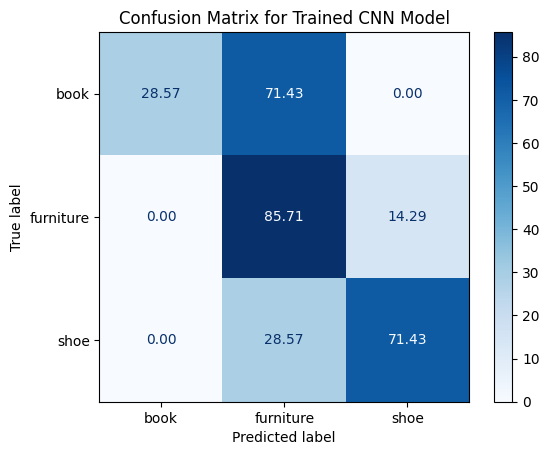

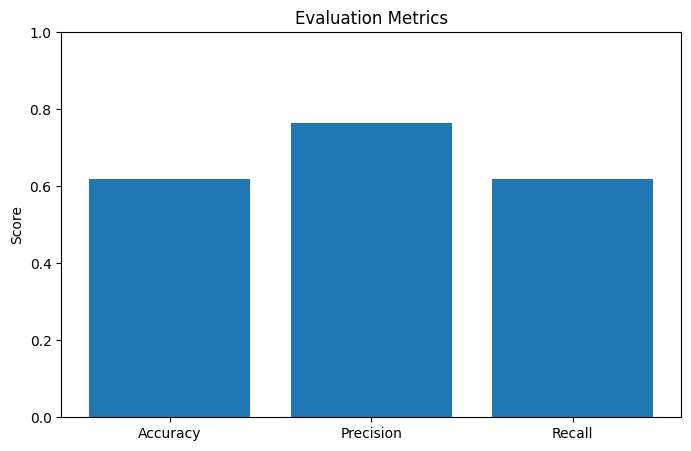

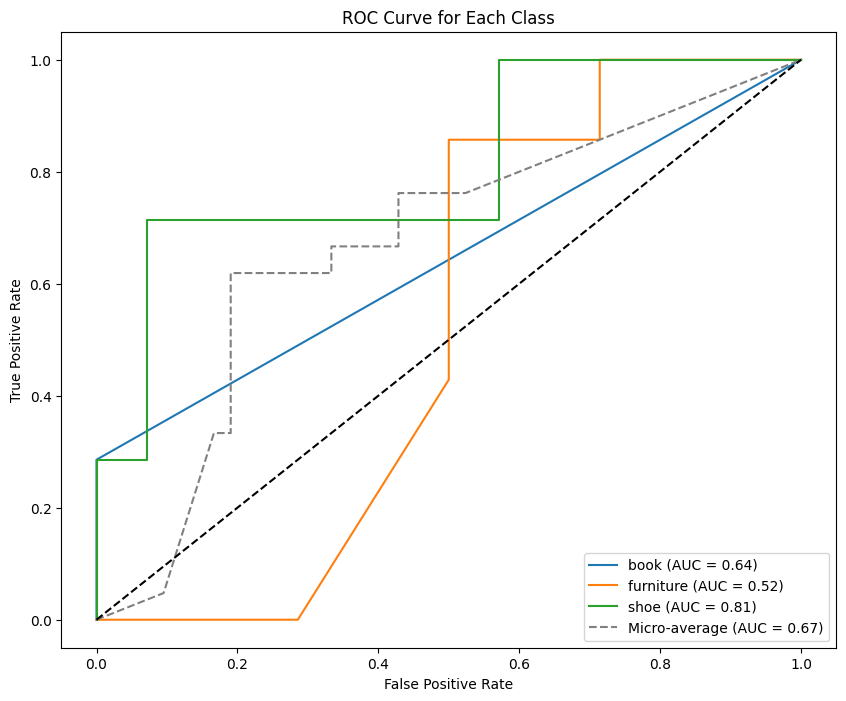

In [ ]:
evaluation(improved_cnn_model, test_images, test_labels)

This final model is by far the best, that we could achieve with such a small dataset to train on. There is definitely room for improvement, but all of the examined metrics are above 60%, which we were satisfied with at this point of the project. It predicts shoes and furnitures pretty well, but it often predicted furniture label on book inputs too.

# Best Version of Model 4

In [1]:
# Download model
!wget --no-check-certificate 'https://www.dropbox.com/scl/fi/jpx02l5fa9a92t6b77keo/MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=1' -O mt.keras


--2024-12-08 19:26:24--  https://www.dropbox.com/scl/fi/jpx02l5fa9a92t6b77keo/MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e49105de93af8004fdff13108.dl.dropboxusercontent.com/cd/0/inline/Cf7t35F88M2vBbidf3Es_0uny3wxuhbwxvNJFU9ebiIxEqm-ZVeswkqu6wbx2EF0eGrFQlSpQmwYZfuoEUcdpjoWvO1bnrCR-7X-SQRUIQQe8CUPjQtDq40yfHOIZPF1yIhUIZFmijzpJ3HnKplPDmdW/file?dl=1# [following]
--2024-12-08 19:26:25--  https://uc1e49105de93af8004fdff13108.dl.dropboxusercontent.com/cd/0/inline/Cf7t35F88M2vBbidf3Es_0uny3wxuhbwxvNJFU9ebiIxEqm-ZVeswkqu6wbx2EF0eGrFQlSpQmwYZfuoEUcdpjoWvO1bnrCR-7X-SQRUIQQe8CUPjQtDq40yfHOIZPF1yIhUIZFmijzpJ3HnKplPDmdW/file?dl=1
Resolving uc1e49105de93af8004fdff13108.dl.dropboxusercontent.com (uc1e49105de93af8004fdff13108.dl.dropboxuserco

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model('mt.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy: 0.71
Precision: 0.85
Recall: 0.71



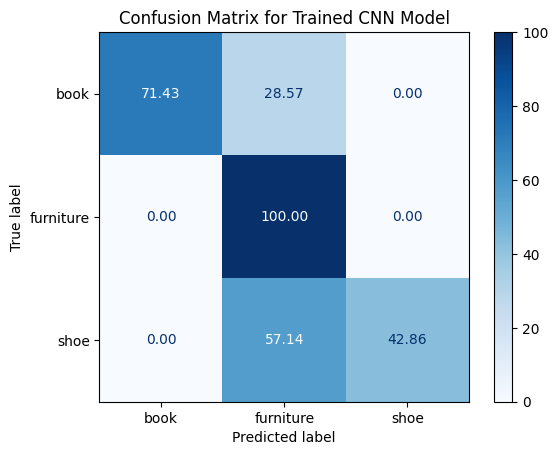

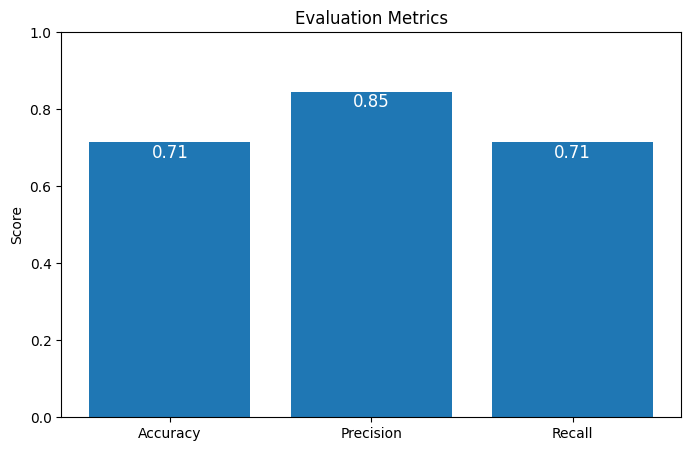

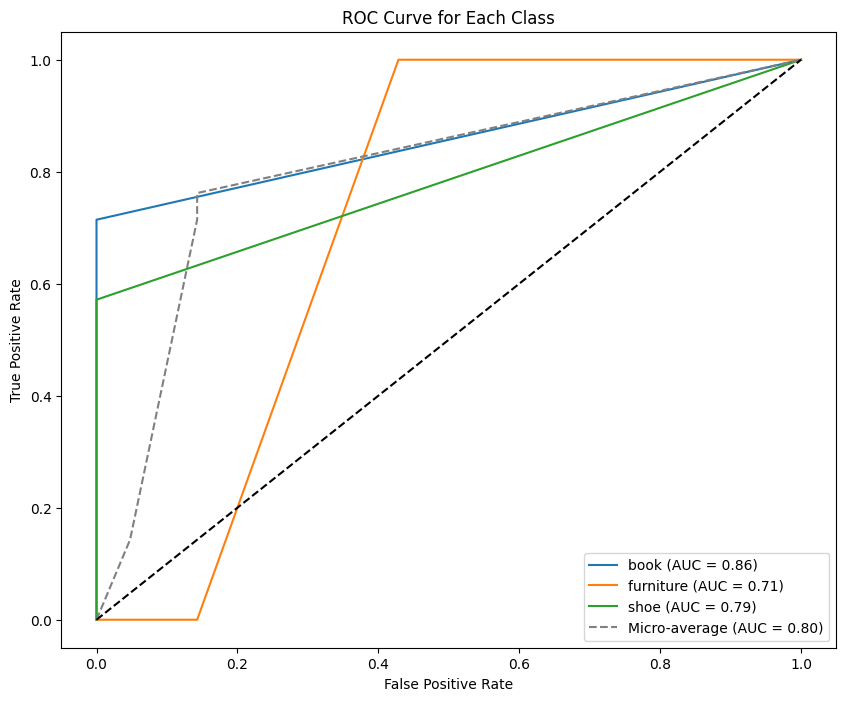

In [18]:
evaluation(model, test_images, test_labels)

# ML as a service - Gradio implementation

In [20]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [21]:
import tensorflow as tf
import gradio as gr
import numpy as np
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model('mt.keras')

# Define the class names
class_names = [ "books","furniture",  "shoes"]

# Define the prediction function
def classify_image(image):
    try:
        # Convert NumPy array to PIL Image if needed
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Resize the image to match the model input size
        image = image.resize((256, 256))

        # Convert the image to array and normalize it
        img_array = np.array(image) / 255.0  # Convert to numpy array and normalize

        # Ensure the image has the expected number of channels
        if img_array.shape[-1] != 3:
            return "The image must be a color image with 3 channels (RGB)."

        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make the prediction
        prediction = model.predict(img_array)
        class_index = np.argmax(prediction)

        return class_names[class_index]
    except Exception as e:
        return f"An error occurred: {str(e)}"

# Create the Gradio interface
interface = gr.Interface(fn=classify_image, inputs="image", outputs="label")
interface.launch(server_name="0.0.0.0", share = False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>